In [1]:
import tweepy
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
from config import consumer_key, consumer_secret, access_token, access_token_secret
import matplotlib.pyplot as plt
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer() # Initialize the class 

In [2]:
# Twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [3]:
news_organization_list = [('BBC', '@BBC'), ('CBS', '@CBS'), ('CNN', '@CNN'), ('Fox', '@FoxNews'), ('New York Times', '@nytimes')]

In [4]:
news_organizations_df = pd.DataFrame(news_organization_list, columns = ['name', 'handle'])

In [5]:
news_organizations_df

,name,handle
0,BBC,@BBC
1,CBS,@CBS
2,CNN,@CNN
3,Fox,@FoxNews
4,New York Times,@nytimes


In [6]:
nbr_tweets = 100

In [7]:
def get_df_for_user_tweets(username):
    try:
        target_tweets = []
        for status in tweepy.Cursor(api.user_timeline, id=username).items(nbr_tweets):
            target_tweets.append(status)
        temp_df = pd.DataFrame([ (x.user._json['screen_name'], x.text, x.created_at, analyzer.polarity_scores(x.text))
                                for x in target_tweets])
        temp_df.columns = ['user', 'tweet_text', 'created', 'sentiment']
        return temp_df
    except Exception as e:
        print(str(e), "Please debug this!")

In [12]:
# Create a 'tweets' DataFrame for each row of the 'news organizations' DataFrame
news_organizations_df['tweets'] = news_organizations_df.handle.map(get_df_for_user_tweets)
# Would it be ok if the funtion get_df_for_user_tweets required a second argument, which was defined here?

In [13]:
def df_to_list(df):
    return list(df.T.to_dict().values())

def normalize_df(df):
    return json_normalize(df_to_list(df))

In [14]:
# Flatten out the 'sentiment' dictionary column of the 'tweets' DataFrames
news_organizations_df['tweets'] = news_organizations_df['tweets'].map(normalize_df)

In [15]:
news_organizations_df['tweets'][0].head()

,created,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,tweet_text,user
0,2018-06-24 18:32:03,-0.5574,0.153,0.847,0.000,🚗 🇸🇦 Women in Saudi Arabia are hitting the roa...,BBC
1,2018-06-24 18:10:27,0.5994,0.000,0.755,0.245,"RT @BBCWthrWatchers: Beautiful ""night shining""...",BBC
2,2018-06-24 18:04:04,-0.5267,0.195,0.805,0.000,This. Will. Hurt.\n\n@IdrisElba returns as the...,BBC
3,2018-06-24 17:08:05,0.6705,0.078,0.658,0.263,43% of female festival goers under 40 say they...,BBC
4,2018-06-24 16:02:06,0.0000,0.106,0.787,0.106,Imagine waking up one morning and you've lost ...,BBC


In [16]:
# Check to make sure tweepy returned all the tweets in reverse chronological order
# To confirm that the sanity check below does actually work, experimentally intervene using the commented line below:
#news_organizations_df['tweets'][1]['created'][1] = datetime.now()

if any((tf['created'][i] - tf['created'][i-1]).total_seconds() > 0 
    for tf in news_organizations_df['tweets']
         for i in range(1, len(tf) - 1)):
       print ("Unexpected timestamp sequence")

In [17]:
def mean(l):
    return sum(l) / len(l)

In [18]:
news_organizations_df['sentiments'] = [x['sentiment.compound'] for x in news_organizations_df.tweets]
news_organizations_df['mean_sentiment'] = [mean(x) for x in news_organizations_df['sentiments']]

In [19]:
news_organizations_df.head()

,name,handle,tweets,sentiments,mean_sentiment
0,BBC,@BBC,created sentiment.compound se...,0 -0.5574 1 0.5994 2 -0.5267 3 0...,0.170314
1,CBS,@CBS,created sentiment.compound se...,0 0.1867 1 0.4199 2 0.4926 3 0...,0.347950
2,CNN,@CNN,created sentiment.compound se...,0 0.0000 1 0.0000 2 0.5859 3 -0...,-0.041831
3,Fox,@FoxNews,created sentiment.compound se...,0 -0.6249 1 0.7096 2 0.0000 3 0...,-0.021228
4,New York Times,@nytimes,created sentiment.compound se...,0 0.2263 1 0.0000 2 0.0000 3 0...,0.037301


In [20]:
now = datetime.now()

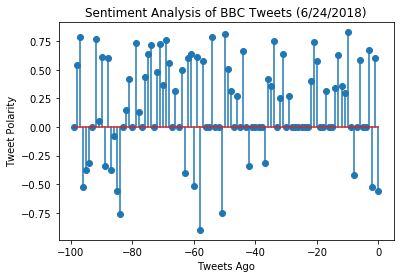

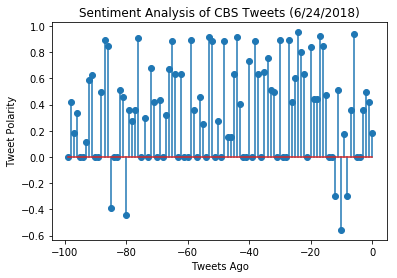

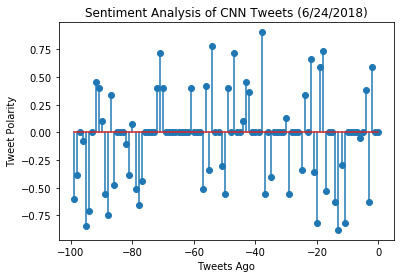

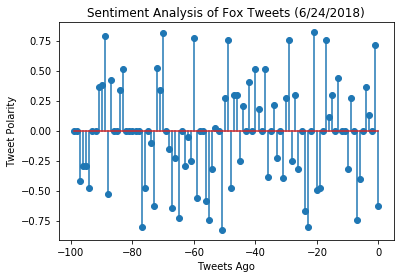

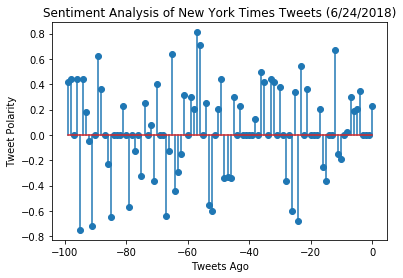

In [38]:
for index, row in news_organizations_df.iterrows():
    #It's a bit tricky to reverse the x axis
    plt.stem(list(range(1-nbr_tweets,1)), list(reversed(row['sentiments'][0:nbr_tweets])))
    plt.title(f"Sentiment Analysis of {row['name']} Tweets ({now.month}/{now.day}/{now.year})")
    plt.xlabel('Tweets Ago')
    plt.ylabel('Tweet Polarity')
    plt.savefig(str(row['name']))
    plt.show()


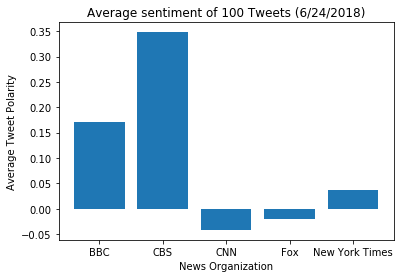

In [22]:
plt.bar(news_organizations_df['name'], news_organizations_df['mean_sentiment']) 
plt.title(f"Average sentiment of {nbr_tweets} Tweets ({now.month}/{now.day}/{now.year})")
plt.xlabel('News Organization')
plt.ylabel('Average Tweet Polarity')
plt.show()

In [23]:
# Convert each 'tweets' DataFrame to a list of dicts
news_organizations_df['tweets'] = [df_to_list(x) for x in news_organizations_df['tweets']]

In [24]:
news_organizations_df

,name,handle,tweets,sentiments,mean_sentiment
0,BBC,@BBC,"[{'created': 2018-06-24 18:32:03, 'sentiment.c...",0 -0.5574 1 0.5994 2 -0.5267 3 0...,0.170314
1,CBS,@CBS,"[{'created': 2018-06-22 21:19:06, 'sentiment.c...",0 0.1867 1 0.4199 2 0.4926 3 0...,0.347950
2,CNN,@CNN,"[{'created': 2018-06-24 18:27:05, 'sentiment.c...",0 0.0000 1 0.0000 2 0.5859 3 -0...,-0.041831
3,Fox,@FoxNews,"[{'created': 2018-06-24 18:35:28, 'sentiment.c...",0 -0.6249 1 0.7096 2 0.0000 3 0...,-0.021228
4,New York Times,@nytimes,"[{'created': 2018-06-24 18:30:08, 'sentiment.c...",0 0.2263 1 0.0000 2 0.0000 3 0...,0.037301


In [25]:
tweets_df = json_normalize(df_to_list(news_organizations_df), 'tweets')

In [26]:
tweets_df.head()

,created,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,tweet_text,user
0,2018-06-24 18:32:03,-0.5574,0.153,0.847,0.000,🚗 🇸🇦 Women in Saudi Arabia are hitting the roa...,BBC
1,2018-06-24 18:10:27,0.5994,0.000,0.755,0.245,"RT @BBCWthrWatchers: Beautiful ""night shining""...",BBC
2,2018-06-24 18:04:04,-0.5267,0.195,0.805,0.000,This. Will. Hurt.\n\n@IdrisElba returns as the...,BBC
3,2018-06-24 17:08:05,0.6705,0.078,0.658,0.263,43% of female festival goers under 40 say they...,BBC
4,2018-06-24 16:02:06,0.0000,0.106,0.787,0.106,Imagine waking up one morning and you've lost ...,BBC


In [28]:
tweets_df.to_csv('Twitter_Sentiments.csv', index = False)